<h1 style="text-align: center;">Jira Reporting Made Easy</h1>
<p style="text-align: center;"><em>Powered by Google ADK &amp; Atlassian MCP</em></p>

**This agent analyzes JIRA ticket cycle times and state workflow transitions through interactive visualizations.** It processes individual ticket changelogs to extract state transitions with timestamps, then generates Sankey diagrams, histograms, and bar charts to reveal workflow patterns and bottlenecks. 

The agent works with any JIRA instance and is perfect for product managers, engineering leads, and process improvement teams who need data-driven insights into their development workflows.

### Key Features

* Sankey Flow Diagrams - Visual workflow paths showing ticket movement between states
* State Time Histograms - Distribution analysis for cycle time spent in specific states
* Comparative Bar Charts - Total time analysis across all workflow states

### Prerequisites
To run the JIRA Ticket Cycle Time & State Workflow Analytics agent with an MCP connection, you need:

* Python 3.13 with a virtual environment (venv).
* JupyterLab (installed inside the venv) or Google Colab
* Node.js - includes npx, which is used to launch the MCP client (mcp-remote) on the fly without a global install.
* Access to the Atlassian MCP endpoint: https://mcp.atlassian.com/v1/sse and permissions to read JIRA ticket data.
* JIRA instance credentials (email, API token, and base URL) configured as environment variables.

In [ ]:
%pip install google-adk mcp jira

In [1]:
import asyncio
import base64
import contextlib
import json
import math
import os
import re
from collections import defaultdict
from datetime import datetime
from typing import List, Optional

import aiohttp
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import display
from jira import JIRA
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

from google import genai
from google.genai import types

from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools.mcp_tool.mcp_toolset import McpToolset, StdioConnectionParams, StdioServerParameters
from google.adk.tools.tool_context import ToolContext

In [2]:
load_dotenv()
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
JIRA_EMAIL = os.getenv("JIRA_EMAIL")
JIRA_API_TOKEN = os.getenv("JIRA_API_TOKEN")
JIRA_URL = os.getenv("JIRA_URL")
if GEMINI_API_KEY:
    print("Google API key loaded!")
else:
    print("Google API key missing!")
if all([JIRA_EMAIL, JIRA_API_TOKEN, JIRA_URL]):
    print("JIRA credentials loaded!")
else:
    print("JIRA credentials missing!")

Google API key loaded!
JIRA credentials loaded!


#### Get Jira Tickets Status Transitions Tool

Behavior:
* Uses Jira Python library to retrieve and parse ticket changelog directly (no LLM involved) for efficiency
* Processes transitions chronologically (oldest to newest)
* Automatically adds self-loop for current status (time spent in current state)
* Handles tickets with no status changes (creates self-loop from creation)
* Validates transition durations don't exceed ticket lifetime
* Prevents duplicate transitions using (issue_key, source_status, target_status) keys
* Continues processing remaining tickets if individual tickets fail

State Management:
* Appends to tool_context.state["ticket_status_transitions"], where each entry contains:
* issue_key (str): JIRA ticket identifier
* source_status (str): Status transitioned from
* target_status (str): Status transitioned to
* transition_days (int): Days spent in source_status before transitioning (minimum 1)

In [3]:
def clean_json_block(content: str) -> str:
    """Strip triple backticks and language identifiers from JSON content."""
    content = re.sub(r"^```json|```$", "", content.strip(), flags=re.IGNORECASE).strip()
    content = content.strip("`").strip()
    return content


# Bulk processing function for multiple tickets
def get_jira_ticket_status_transitions(tool_context: ToolContext, issue_keys: List[str]) -> str:
    """
    Extract and store status transition history for multiple JIRA tickets.
    
    This tool processes JIRA issue changelogs to build a complete transition history for each ticket,
    including time spent in each status. Transitions are stored in tool_context.state for downstream
    analysis (e.g., cycle time analysis, bottleneck detection, workflow optimization).
    
    Args:
        tool_context (ToolContext): Context object for state management across tool calls.
        issue_keys (List[str]): JIRA issue keys to process (e.g., ["PROJ-123", "PROJ-124"]).
    
    Returns:
        str: Summary message with processing statistics:
            - Number of tickets processed
            - New transitions added
            - Duplicates skipped
            - Errors encountered
            - Total transitions in context
    """
    
    try:
        # print(f"🔍 [{get_jira_ticket_status_transitions}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        # print(f"🔍 [{get_jira_ticket_status_transitions}] Context ID: {id(tool_context.state)}")
        print(f"Processing {len(issue_keys)} tickets: {', '.join(issue_keys)}")
        
        # Initialize JIRA client
        jira = JIRA(JIRA_URL, basic_auth=(JIRA_EMAIL, JIRA_API_TOKEN))
        
        # Get current date
        current_date = datetime.now()
        
        # Initialize storage if needed
        if "ticket_status_transitions" not in tool_context.state:
            tool_context.state["ticket_status_transitions"] = []
        
        # Get existing transitions for duplicate checking
        existing_transitions = tool_context.state["ticket_status_transitions"]
        existing_keys = set()
        for existing in existing_transitions:
            key = (existing["issue_key"], existing["source_status"], existing["target_status"])
            existing_keys.add(key)
        
        # Counters for all tickets
        total_valid_count = 0
        total_duplicate_count = 0
        all_extracted_transitions = []
        errors = []
        
        # Process each ticket
        for issue_key in issue_keys:
            try:
                print(f"\n📄 Processing {issue_key}...")
                
                # Get issue with changelog
                issue = jira.issue(issue_key, expand='changelog')
                
                # Get creation date for ticket lifetime calculation
                creation_date = datetime.fromisoformat(issue.fields.created.replace('Z', '+00:00'))
                ticket_lifetime_days = (current_date.replace(tzinfo=creation_date.tzinfo) - creation_date).days + 1
                print(f"   Ticket lifetime: {ticket_lifetime_days} days (created: {creation_date.strftime('%Y-%m-%d')})")

                # Parse transitions directly from changelog
                transitions = []
                prev_status = "Backlog"  
                prev_date = issue.fields.created
                
                # CRITICAL: Process changelog in chronological order (oldest first)
                for history in reversed(issue.changelog.histories):  # ← Add reversed() here!
                    for item in history.items:
                        if item.field == 'status':
                            # Always record the transition
                            from_date = datetime.fromisoformat(prev_date.replace('Z', '+00:00'))
                            to_date = datetime.fromisoformat(history.created.replace('Z', '+00:00'))
                            days = max(1, (to_date - from_date).days + 1)
                            
                            transitions.append({
                                "issue_key": issue_key,
                                "source_status": prev_status,
                                "target_status": item.toString,
                                "transition_days": days,
                                "from_date": prev_date,
                                "to_date": history.created
                            })
                            
                            prev_status = item.toString
                            prev_date = history.created
                
                # Handle case where ticket has no status changes (self-loop)
                if not transitions:
                    # Create self-loop from creation to now with initial status
                    initial_status = issue.fields.status.name
                    days = max(1, ticket_lifetime_days)
                    
                    transitions.append({
                        "issue_key": issue_key,
                        "source_status": initial_status,
                        "target_status": initial_status,
                        "transition_days": days,
                        "from_date": issue.fields.created,
                        "to_date": current_date.isoformat()
                    })
                    print(f"   ⚠️  No status changes - created self-loop: {initial_status} ({days} days)")
                else:
                    # Add final self-loop for current status
                    current_status = issue.fields.status.name
                    last_transition_date = datetime.fromisoformat(prev_date.replace('Z', '+00:00'))
                    days = max(1, (current_date.replace(tzinfo=last_transition_date.tzinfo) - last_transition_date).days + 1)
                    
                    transitions.append({
                        "issue_key": issue_key,
                        "source_status": current_status,
                        "target_status": current_status,
                        "transition_days": days,
                        "from_date": prev_date,
                        "to_date": current_date.isoformat()
                    })
                    print(f"   ✓ Found {len(transitions)-1} status changes + 1 current status self-loop")
                
                # Add transitions to storage with duplicate prevention
                valid_count = 0
                duplicate_count = 0
                
                for transition in transitions:
                    # Create final transition object
                    final_transition = {
                        "issue_key": transition["issue_key"],
                        "source_status": transition["source_status"],
                        "target_status": transition["target_status"],
                        "transition_days": transition["transition_days"]
                    }
                    
                    # Check for duplicates
                    key = (final_transition["issue_key"], final_transition["source_status"], final_transition["target_status"])
                    
                    if key in existing_keys:
                        duplicate_count += 1
                        print(f"   🔄 Skipped duplicate: {final_transition['source_status']} → {final_transition['target_status']}")
                    else:
                        # Validate transition days don't exceed ticket lifetime
                        if final_transition["transition_days"] > ticket_lifetime_days:
                            print(f"   ❌ INVALID: {final_transition['source_status']} → {final_transition['target_status']} shows {final_transition['transition_days']} days but ticket only exists for {ticket_lifetime_days} days")
                            continue
                        
                        tool_context.state["ticket_status_transitions"].append(final_transition)
                        existing_keys.add(key)
                        all_extracted_transitions.append(final_transition)
                        valid_count += 1
                
                total_valid_count += valid_count
                total_duplicate_count += duplicate_count
                print(f"   ✅ {issue_key}: +{valid_count} new, -{duplicate_count} duplicates")
                
            except Exception as e:
                error_msg = f"{issue_key}: {str(e)}"
                errors.append(error_msg)
                print(f"   ❌ Error processing {issue_key}: {str(e)}")
                continue
        
        # Print final results
        print(f"\n{'='*60}")
        print(f"BULK STATUS TRANSITIONS PROCESSED")
        print(f"{'='*60}")
        print(f"📊 Processed {len(issue_keys)} tickets")
        print(f"✅ Added: {total_valid_count} new transitions")
        if total_duplicate_count > 0:
            print(f"🔄 Skipped: {total_duplicate_count} duplicates")
        if errors:
            print(f"❌ Errors: {len(errors)} tickets failed")
            for error in errors:
                print(f"   - {error}")
        print(f"📈 Total in context: {len(tool_context.state['ticket_status_transitions'])} transitions")
        
        if all_extracted_transitions:
            print(f"\n📈 New transitions added:")
            for i, transition in enumerate(all_extracted_transitions, 1):
                print(f"{i}. {transition['issue_key']}: {transition['source_status']} → {transition['target_status']} ({transition['transition_days']} days)")
        
        print(f"{'='*60}\n")
        
        success_msg = f"✅ Processed {len(issue_keys)} tickets: +{total_valid_count} new, -{total_duplicate_count} duplicates"
        if errors:
            success_msg += f", {len(errors)} errors"
        success_msg += f", {len(tool_context.state['ticket_status_transitions'])} total"
        
        return success_msg
        
    except Exception as e:
        return f"❌ Error in bulk processing: {str(e)}"

#### Create Sankey Diagram Tool

Visualization Features:
* Flow aggregation: Combines transitions between same status pairs across all tickets
* Flow thickness: Proportional to total days spent in that transition
* Interactive hover: Shows individual tickets and days for each flow
* Self-loop handling: Converts source→source transitions to "Currently in {status}" nodes
* End status optimization: Excludes self-loops for Done/Closed statuses to prevent clutter

In [4]:
def create_sankey_diagram(tool_context: ToolContext, title: str = "JIRA Status Flow") -> str:
    """
    Creates a Sankey diagram from transition data stored in tool_context.
    
    This tool creates a flow diagram showing how tickets move through different statuses over time,
    with flow thickness representing total days spent in each transition. Ideal for identifying
    workflow bottlenecks, understanding team velocity, and visualizing ticket lifecycle patterns.
    
    
    Args:
        tool_context: The tool context containing ticket_status_transitions data
        title: Title for the diagram
    
    Returns:
        str: Success message with statistics (e.g., "Sankey diagram created with 45 transitions")
            or error message if visualization fails.
        
    Expected data in tool_context.state["ticket_status_transitions"]:
    [
        {
            "issue_key": "PROJ-123",
            "source_status": "Backlog", 
            "target_status": "In Progress",
            "transition_days": 3
        }
    ]
    """
    
    try:
        # print(f"🔍 [{create_sankey_diagram}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        # print(f"🔍 [{create_sankey_diagram}] Context ID: {id(tool_context.state)}")
        
        # Initialize notebook mode for plotly
        init_notebook_mode(connected=True)
        
        # Get transition data from context
        transitions = tool_context.state.get("ticket_status_transitions", [])
        
        if not transitions:
            return "❌ No transition data found in context. Run get_jira_ticket_status_transitions first."
        
        # Create and display DataFrame of raw transition data
        df = pd.DataFrame(transitions)
        df['note'] = df.apply(lambda row: 
            "(self-loop)" if row['source_status'] == row['target_status']
            else "(from beginning)" if row['source_status'] in {"New", "Backlog"}
            else "(to end)" if row['target_status'] in {"Done", "Closed"}
            else "", axis=1)
        
        print(f"\n📋 Raw Transition Data for Sankey Diagram")
        print(f"{'='*80}")
        display(df[['issue_key', 'source_status', 'target_status', 'transition_days', 'note']])
        print(f"{'='*80}\n")
        
        # Define end statuses that should not have "Currently in X" nodes
        END_STATUSES = {"Done", "Closed"}
        
        # Aggregate transitions and collect ticket details
        aggregated = {}
        all_statuses = set()
        
        for transition in transitions:
            source = transition["source_status"]
            target = transition["target_status"]
            days = transition["transition_days"]
            ticket = transition["issue_key"]
            
            all_statuses.add(source)
            all_statuses.add(target)
            
            key = (source, target)
            if key not in aggregated:
                aggregated[key] = {"total_days": 0, "tickets": []}
            
            aggregated[key]["total_days"] += days
            aggregated[key]["tickets"].append(f"{ticket}:{days}d")

        # Handling of self-loops - end statuses are excluded
        new_aggregated = {}
        for (source, target), data in aggregated.items():
            if source == target:
                # Only create virtual nodes for non-end statuses
                if target not in END_STATUSES:
                    # Create virtual node: "Currently in {status}"
                    virtual_status = f"Currently in {source}"
                    all_statuses.add(virtual_status)
                    # Use virtual status as target
                    new_aggregated[(source, virtual_status)] = data
                # For end statuses, skip creating the self-loop entirely
                # This means tickets that end in Done/Closed won't show artificial flows
            else:
                new_aggregated[(source, target)] = data
        
        aggregated = new_aggregated
        
        if not aggregated:
            return "❌ No valid transitions found to visualize."
        
        # Create status mapping with end statuses positioned last
        end_statuses_in_data = [s for s in all_statuses if s in END_STATUSES]
        non_end_statuses = [s for s in all_statuses if s not in END_STATUSES]
        
        # Sort each group separately, then combine with end statuses last
        status_list = sorted(non_end_statuses) + sorted(end_statuses_in_data)
        status_to_id = {status: idx for idx, status in enumerate(status_list)}
        
        # Build nodes (let Plotly handle colors)
        node_labels = status_list
        
        # Build links with ticket information
        link_sources = []
        link_targets = []
        link_values = []
        link_labels = []
        
        for (source, target), data in aggregated.items():
            source_id = status_to_id[source]
            target_id = status_to_id[target]
            total_days = data["total_days"]
            tickets = data["tickets"]
            
            link_sources.append(source_id)
            link_targets.append(target_id)
            link_values.append(total_days)
            
            # Create hover label with ticket details
            if source == target:
                flow_text = f"{source} (current)"
            else:
                flow_text = f"{source} → {target}"
            
            ticket_list = ", ".join(tickets)
            hover_label = f"{flow_text}: {total_days} days<br>Tickets: {ticket_list}"
            link_labels.append(hover_label)
        
        # Create Sankey diagram
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=node_labels
                # Let Plotly auto-assign colors
            ),
            link=dict(
                source=link_sources,
                target=link_targets,
                value=link_values,
                label=link_labels,
                hovertemplate='%{label}<extra></extra>'
                # Let Plotly auto-assign colors
            )
        )])
        
        # Update layout
        fig.update_layout(
            title_text=f"{title}<br><sub>Flow values represent total days spent in transitions</sub>",
            font_size=12,
            width=1000,
            height=600
        )
        
        # Display the diagram
        iplot(fig)
        
        # Print summary
        total_transitions = len(transitions)
        unique_tickets = len(set(t["issue_key"] for t in transitions))
        total_days = sum(t["transition_days"] for t in transitions)
        
        print(f"\n📊 Sankey Diagram Created: {title}")
        print(f"   • {total_transitions} transitions visualized")
        print(f"   • {unique_tickets} unique tickets")
        print(f"   • {total_days} total days tracked")
        print(f"   • Hover over flows to see ticket details\n")
        
        return f"✅ Sankey diagram created with {total_transitions} transitions"
        
    except Exception as e:
        return f"❌ Error creating Sankey diagram: {str(e)}"


#### Create Bar Chart Tool

Chart Features:
* Time aggregation: Sums all days spent in each status across all tickets
* Self-loop inclusion: Includes time spent in current status (source == target transitions)
* Status filtering: Excludes beginning statuses (New, Backlog) and end statuses (Done, Closed)
* Descending sort: Bars ordered by total time spent (highest first)

_Filtering Logic_

INCLUDED in chart:
* All intermediate workflow statuses (In Progress, Code Review, Testing, Blocked, etc.)
* Self-loops showing time in current status
        
EXCLUDED from chart:
* Beginning statuses: New, Backlog (entry points don't represent work time)
* End statuses: Done, Closed (completion states don't represent active work)
    

In [5]:
def create_jira_ticket_status_time_bar_chart(tool_context: ToolContext, title: str = "Time Spent in Each Status") -> str:
    """
    Creates a bar chart showing total time spent in each status across all tickets. 
    Historical completed time in each status and not the current/ongoing time for tickets in the given status.
    Excludes beginning statuses (New, Backlog) and end statuses (Done, Closed).
    
    Args:
        tool_context: The tool context containing ticket_status_transitions data
        title: Title for the chart
    
    Returns:
        str: Success message with statistics (e.g., "Bar chart created showing 5 statuses with 
            127 total days (includes self-loops)") or error message if visualization fails.
        
    Expected data in tool_context.state["ticket_status_transitions"]:
    [
        {
            "issue_key": "PROJ-123",
            "source_status": "Backlog", 
            "target_status": "In Progress",
            "transition_days": 3
        }
    ]
    """
    
    try:
        # print(f"🔍 [{create_jira_ticket_status_time_bar_chart}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        # print(f"🔍 [{create_jira_ticket_status_time_bar_chart}] Context ID: {id(tool_context.state)}")
        
        # Initialize notebook mode for plotly
        init_notebook_mode(connected=True)
        
        # Get transition data from context
        transitions = tool_context.state.get("ticket_status_transitions", [])
        
        if not transitions:
            return "❌ No transition data found in context. Run get_jira_ticket_status_transitions first."
        
        # Display raw transition data as DataFrame (same as other tools)
        df = pd.DataFrame(transitions)
        df['note'] = df.apply(lambda row: 
            "(self-loop)" if row['source_status'] == row['target_status']
            else "(from beginning)" if row['source_status'] in {"New", "Backlog"}
            else "(to end)" if row['target_status'] in {"Done", "Closed"}
            else "", axis=1)
        
        print(f"\n📋 Raw Transition Data for Bar Chart Analysis")
        print(f"{'='*80}")
        display(df[['issue_key', 'source_status', 'target_status', 'transition_days', 'note']])
        print(f"{'='*80}\n")
        
        # Define statuses to exclude from the chart
        BEGINNING_STATUSES = {"New", "Backlog"}
        END_STATUSES = {"Done", "Closed"}
        EXCLUDED_STATUSES = BEGINNING_STATUSES | END_STATUSES
        
        # Aggregate time spent in each status (INCLUDE SELF-LOOPS)
        status_time = defaultdict(int)
        status_tickets = defaultdict(list)  # Track which tickets contributed to each status
        
        for transition in transitions:
            source_status = transition["source_status"]
            target_status = transition["target_status"]
            days = transition["transition_days"]
            ticket = transition["issue_key"]
            
            # Time spent IN a status includes both transitions FROM that status AND self-loops
            if source_status not in EXCLUDED_STATUSES:
                status_time[source_status] += days
                if source_status == target_status:
                    status_tickets[source_status].append(f"{ticket}:{days}d (self-loop)")
                else:
                    status_tickets[source_status].append(f"{ticket}:{days}d")
        
        if not status_time:
            return "❌ No valid status time data found. All transitions involve beginning/end statuses."
        
        print(f"🔍 Time aggregation for each status:")
        for status in sorted(status_time.keys()):
            total_time = status_time[status]
            tickets = status_tickets[status]
            print(f"   • {status}: {total_time} days ({len(tickets)} entries)")
            for ticket in tickets:
                print(f"     - {ticket}")
        print()
        
        # Sort statuses by total time (descending)
        sorted_statuses = sorted(status_time.items(), key=lambda x: x[1], reverse=True)
        
        statuses = [status for status, _ in sorted_statuses]
        times = [time for _, time in sorted_statuses]
        
        # Create hover text with ticket details
        hover_texts = []
        for status in statuses:
            total_time = status_time[status]
            tickets = status_tickets[status]
            ticket_count = len(tickets)
            ticket_list = ", ".join(tickets[:5]) 
            if len(tickets) > 5:
                ticket_list += f" (+{len(tickets)-5} more)"
            
            hover_text = f"Status: {status}<br>Total Days: {total_time}<br>Entries: {ticket_count}<br>Details: {ticket_list}"
            hover_texts.append(hover_text)
        
        # Create bar chart
        fig = go.Figure(data=[
            go.Bar(
                x=statuses,
                y=times,
                text=[f"{time}d" for time in times],  # Show days on bars
                textposition='auto',
                hovertemplate='%{customdata}<extra></extra>',
                customdata=hover_texts,
                marker=dict(
                    color=times,
                    colorscale='Viridis',
                    showscale=False,
                    colorbar=dict(title="Days")
                )
            )
        ])
        
        # Update layout
        fig.update_layout(
            title=f"{title}<br><sub>Includes self-loops, excludes beginning (New, Backlog) and end (Done, Closed) statuses</sub>",
            xaxis_title="Status",
            yaxis_title="Total Days",
            font_size=12,
            width=1000,
            height=600,
            xaxis={'categoryorder': 'total descending'},  # Ensure bars are sorted by value
            # yaxis=dict(
            #     dtick=10,  # Set tick interval to 1 day
            #     tick0=0   # Start ticks at 0
            # )
            # yaxis=dict(
            #     rangemode='tozero',  # Start from 0
            #     # dtick will auto-calculate, or set to something like 10 for cleaner intervals
            # )
        )
        
        # Display chart
        iplot(fig)
        
        # Print summary
        total_statuses = len(statuses)
        total_days = sum(times)
        unique_tickets = len(set(t["issue_key"] for t in transitions))
        
        print(f"\n📊 Status Time Bar Chart Created: {title}")
        print(f"   • {total_statuses} active statuses analyzed")
        print(f"   • {total_days} total days across all statuses (includes self-loops)")
        print(f"   • {unique_tickets} unique tickets")
        print(f"   • Excludes: {', '.join(sorted(EXCLUDED_STATUSES))}")
        print(f"   • Hover over bars to see ticket details\n")
        
        # Print top statuses
        print("📈 Top statuses by time spent:")
        for i, (status, time) in enumerate(sorted_statuses[:5], 1):
            entry_count = len(status_tickets[status])
            print(f"   {i}. {status}: {time} days ({entry_count} entries)")
        
        if len(sorted_statuses) > 5:
            print(f"   ... and {len(sorted_statuses) - 5} more statuses")
        print()
        
        return f"✅ Bar chart created showing {total_statuses} statuses with {total_days} total days (includes self-loops)"
        
    except Exception as e:
        return f"❌ Error creating status time bar chart: {str(e)}"

#### Create Status Histogram Tool

Chart Features:
* Per-ticket aggregation: Sums all time a ticket spent in the status (multiple visits + self-loops)
* Granular bucketing: 1-day buckets from 1d to 30d, plus a 30+d overflow bucket
* Smart range: Displays only bins with data or near data (minimum 5 days shown)
* Statistical overlays: Vertical lines for median and 90th percentile
* Bottleneck metrics: Automatic classification into Fast/Slow/Very Slow categories
    
_Status Filtering_

ALLOWED statuses:
* All intermediate workflow statuses (In Progress, Code Review, Testing, Blocked, etc.)
        
REJECTED statuses:
* Beginning: New, Backlog (entry points don't represent work time)
* End: Done, Closed (completion states don't represent active work)
* Returns error with list of available statuses if invalid status provided
    
Time Aggregation Logic - For each ticket, sums ALL time where source_status == target status:
* Regular transitions: Time leaving that status
* Self-loops: Time remaining in that status (current state)
* Multiple visits: If ticket returns to status, time is cumulative
        
Example: PROJ-123 in "Code Review"
* First visit: 2 days (transitioned to Testing)
* Returned later: 3 days (self-loop, still in Code Review)
* Total time: 5 days (shown as single histogram entry)

In [6]:
def create_jira_ticket_status_histogram(tool_context: ToolContext, status: str, title: Optional[str] = None) -> str:
    """
    Creates a histogram showing the distribution of time spent in a specific status.
    Shows time intervals from 1-30 days (individual buckets) plus 30+ days bucket.
    Includes statistical annotations for bottleneck analysis.
  
    Args:
        tool_context: The tool context containing ticket_status_transitions data
        status: The specific status to analyze (case-sensitive)
        title: Optional custom title for the chart
    
    Returns:
        Success/error message as string
        
    Expected data in tool_context.state["ticket_status_transitions"]:
    [
        {
            "issue_key": "PROJ-123",
            "source_status": "In Progress", 
            "target_status": "Code Review",
            "transition_days": 3
        }
    ]
    """
    
    try:
        # print(f"🔍 [{create_jira_ticket_status_histogram}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        # print(f"🔍 [{create_jira_ticket_status_histogram}] Context ID: {id(tool_context.state)}")
        
        # Initialize notebook mode for plotly
        init_notebook_mode(connected=True)
        
        # Get transition data from context
        transitions = tool_context.state.get("ticket_status_transitions", [])
        
        if not transitions:
            return "❌ No transition data found in context. Run get_jira_ticket_status_transitions first."
        
        # Display raw transition data as DataFrame (same as Sankey)
        df = pd.DataFrame(transitions)
        df['note'] = df.apply(lambda row: 
            "(self-loop)" if row['source_status'] == row['target_status']
            else "(from beginning)" if row['source_status'] in {"New", "Backlog"}
            else "(to end)" if row['target_status'] in {"Done", "Closed"}
            else "", axis=1)
        
        print(f"\n📋 Raw Transition Data for Histogram Analysis")
        print(f"{'='*80}")
        display(df[['issue_key', 'source_status', 'target_status', 'transition_days', 'note']])
        print(f"{'='*80}\n")
        
        # Define statuses to exclude from analysis
        BEGINNING_STATUSES = {"New", "Backlog"}
        END_STATUSES = {"Done", "Closed"}
        EXCLUDED_STATUSES = BEGINNING_STATUSES | END_STATUSES
        
        # Validate the requested status
        if status in EXCLUDED_STATUSES:
            return f"❌ Cannot analyze '{status}' - it's a beginning or end status. Choose from active workflow statuses."

        # Collect time data for the specified status (SUM TIME PER TICKET)
        ticket_time_map = {}  # ticket_key -> total_days
        ticket_details = []   # For hover information
        
        for transition in transitions:
            source_status = transition["source_status"]
            target_status = transition["target_status"]
            days = transition["transition_days"]
            ticket = transition["issue_key"]
            
            # Time spent IN the specified status
            # This includes both transitions FROM that status AND self-loops IN that status
            if source_status == status:
                if ticket not in ticket_time_map:
                    ticket_time_map[ticket] = 0
                ticket_time_map[ticket] += days
        
        # Convert to lists for further processing
        status_times = list(ticket_time_map.values())
        ticket_details = [f"{ticket} ({total_days}d)" for ticket, total_days in ticket_time_map.items()]
        
        if not status_times:
            available_statuses = set()
            for t in transitions:
                if t["source_status"] not in EXCLUDED_STATUSES:
                    available_statuses.add(t["source_status"])
            
            available_list = sorted(list(available_statuses))
            return f"❌ No time data found for status '{status}'. Available statuses: {available_list}"
        
        print(f"🔍 Found {len(status_times)} time entries for '{status}' status:")
        for detail in ticket_details:
            print(f"   • {detail}")
        print()
        
        # Calculate statistics
        times_array = np.array(status_times)
        stats = {
            'count': len(status_times),
            'median': np.median(times_array),
            'mean': np.mean(times_array),
            'p90': np.percentile(times_array, 90),
            'min': np.min(times_array),
            'max': np.max(times_array)
        }
        
        # Create histogram buckets: 1-30 days individually, then 30+ days
        max_individual_bucket = 30
        
        # Create bins: [0.5, 1.5, 2.5, ..., 30.5, inf]
        bins = [i + 0.5 for i in range(max_individual_bucket + 1)]
        bins.append(float('inf'))
        
        # Calculate histogram
        hist_counts, _ = np.histogram(status_times, bins=bins)
        
        # Only show bins that have data or are within reasonable range of data
        max_data_day = min(int(np.max(times_array)), max_individual_bucket)
        display_range = max(max_data_day + 2, 5)  # Show at least 5 days, or max + 2
        display_range = min(display_range, max_individual_bucket)
        
        # Create bin labels and data for display range only
        bin_labels = []
        bin_counts = []
        hover_texts = []
        
        for i in range(display_range):
            day = i + 1
            bin_labels.append(f"{day}d")
            bin_counts.append(hist_counts[i])
            
            # Create hover text
            tickets_in_bin = [detail for detail, time in zip(ticket_details, status_times) if time == day]
            
            if hist_counts[i] > 0:
                ticket_list = ", ".join(tickets_in_bin[:5])  # Show first 5 tickets
                if len(tickets_in_bin) > 5:
                    ticket_list += f" (+{len(tickets_in_bin)-5} more)"
                hover_text = f"Time: {day}d<br>Tickets: {hist_counts[i]}<br>Examples: {ticket_list}"
            else:
                hover_text = f"Time: {day}d<br>Tickets: 0"
            
            hover_texts.append(hover_text)
        
        # Add 30+ bucket if there's data beyond display range
        if np.max(times_array) > max_individual_bucket:
            bin_labels.append("30+d")
            bin_counts.append(hist_counts[-1])  # Last bin is 30+ days
            
            tickets_in_bin = [detail for detail, time in zip(ticket_details, status_times) if time > max_individual_bucket]
            
            if hist_counts[-1] > 0:
                ticket_list = ", ".join(tickets_in_bin[:5])
                if len(tickets_in_bin) > 5:
                    ticket_list += f" (+{len(tickets_in_bin)-5} more)"
                hover_text = f"Time: 30+d<br>Tickets: {hist_counts[-1]}<br>Examples: {ticket_list}"
            else:
                hover_text = f"Time: 30+d<br>Tickets: 0"
            
            hover_texts.append(hover_text)
        
        # Create histogram
        fig = go.Figure(data=[
            go.Bar(
                x=bin_labels,
                y=bin_counts,
                text=bin_counts,
                textposition='auto',
                hovertemplate='%{customdata}<extra></extra>',
                customdata=hover_texts,
                marker=dict(
                    color=bin_counts,
                    colorscale='Blues',
                    showscale=False,
                    colorbar=dict(title="Ticket Count")
                )
            )
        ])
        
        # Add statistical annotation lines (only if they're at different positions)
        if abs(stats['median'] - stats['p90']) > 0.1:
            # Different positions - show both lines
            fig.add_vline(
                x=stats['median'] - 0.5, 
                line_dash="dash", 
                line_color="red", 
                annotation_text=f"Median: {stats['median']:.1f}d",
                annotation_position="top left"
            )
            
            fig.add_vline(
                x=stats['p90'] - 0.5, 
                line_dash="dot", 
                line_color="orange", 
                annotation_text=f"90th percentile: {stats['p90']:.1f}d",
                annotation_position="top right"
            )
        else:
            # Same or very close positions - show combined line
            fig.add_vline(
                x=stats['median'] - 0.5, 
                line_dash="dash", 
                line_color="red", 
                annotation_text=f"Median & 90th percentile: {stats['median']:.1f}d",
                annotation_position="top"
            )
        
        # Set title
        if title is None:
            title = f"Time Distribution for Status: {status}"
        
        # Update layout
        fig.update_layout(
            title=f"{title}<br><sub>Distribution of days spent in '{status}' status (includes self-loops)</sub>",
            xaxis_title="Days Spent in Status",
            yaxis_title="Number of Tickets",
            font_size=12,
            width=1200,
            height=600,
            showlegend=False,
            xaxis=dict(
                type='category',
                categoryorder='array',
                categoryarray=bin_labels,
                # Remove gaps between bars
                range=[-0.5, len(bin_labels) - 0.5]
            ),
            # Remove default margins that cause gaps
            margin=dict(l=50, r=50, t=80, b=50)
        )
        
        # Display the chart
        iplot(fig)
        
        # Print detailed statistics
        print(f"\n📊 Status Time Distribution: {status}")
        print(f"{'='*50}")
        print(f"📈 Statistics:")
        print(f"   • Total tickets analyzed: {stats['count']} (includes self-loops)")
        print(f"   • Average time: {stats['mean']:.1f} days")
        print(f"   • Median time: {stats['median']:.1f} days")
        print(f"   • 90th percentile: {stats['p90']:.1f} days")
        print(f"   • Range: {stats['min']:.0f} - {stats['max']:.0f} days")
        
        # Bottleneck analysis
        print(f"\n🔍 Bottleneck Analysis:")
        quick_tickets = sum(1 for t in status_times if t <= 3)
        slow_tickets = sum(1 for t in status_times if t > 7)
        very_slow_tickets = sum(1 for t in status_times if t > 14)
        
        quick_pct = (quick_tickets / stats['count']) * 100
        slow_pct = (slow_tickets / stats['count']) * 100
        very_slow_pct = (very_slow_tickets / stats['count']) * 100
        
        print(f"   • Fast (≤3 days): {quick_tickets} tickets ({quick_pct:.1f}%)")
        print(f"   • Slow (>7 days): {slow_tickets} tickets ({slow_pct:.1f}%)")
        print(f"   • Very slow (>14 days): {very_slow_tickets} tickets ({very_slow_pct:.1f}%)")
        
        # Recommendations
        print(f"\n💡 Insights:")
        if stats['p90'] > stats['median'] * 3:
            print(f"   ⚠️  High variability detected - some tickets take much longer")
        if very_slow_pct > 10:
            print(f"   🚨 Bottleneck warning - {very_slow_pct:.1f}% of tickets are very slow")
        if quick_pct > 80:
            print(f"   ✅ Good flow - most tickets move quickly through {status}")
        
        print(f"{'='*50}\n")
        
        return f"✅ Histogram created for '{status}' status with {stats['count']} tickets analyzed (includes self-loops)"
        
    except Exception as e:
        return f"❌ Error creating status histogram: {str(e)}"

#### Helper Tools

In [7]:
def clear_status_transitions_data_set(tool_context: ToolContext) -> str:
    """
    Clears all cached transition data to provide a clean slate for new analysis.
    
    Args:
        tool_context: The tool context for state management
    
    Returns:
        Success message as string
    """
    
    try:
        print(f"🔍 [{clear_status_transitions_data_set}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        
        # Get the current count before clearing
        previous_count = len(tool_context.state.get("ticket_status_transitions", []))
        
        # Clear by setting to empty list instead of deleting
        tool_context.state["ticket_status_transitions"] = []
        
        if previous_count > 0:
            print("Data cleared successfully!")
            print(f"   • Cleared: {previous_count} transitions")
            print("   • Ready for fresh analysis")
            return f"Status transitions set is now empty - cleared {previous_count} transitions"
        else:
            print("Status transitions set was already empty!")
            return "Status transitions set is empty - context is clean"
        
    except Exception as e:
        print(f"❌ Clear error: {str(e)}")
        return f"Error clearing data: {str(e)}"


def get_status_transitions_summary(tool_context: ToolContext) -> str:
    """
    Shows a summary of currently stored transition data without creating visualizations.
    Displays data in a nice DataFrame table for easy analysis.
    
    Args:
        tool_context: The tool context for state management
    
    Returns:
        Summary information as string
    """
    
    try:
        # print(f"🔍 [{get_status_transitions_summary}] State check: {len(tool_context.state.get('ticket_status_transitions', []))} transitions in context")
        # print(f"🔍 [{get_status_transitions_summary}] Context ID: {id(tool_context.state)}")
        
        transitions = tool_context.state.get("ticket_status_transitions", [])
        
        print("Current Status Transitions Data Summary")
        print("=" * 50)
        
        if transitions:
            unique_tickets = set(t["issue_key"] for t in transitions)
            unique_statuses = set()
            for t in transitions:
                unique_statuses.add(t["source_status"])
                unique_statuses.add(t["target_status"])
            
            total_days = sum(t["transition_days"] for t in transitions)
            
            print("Transition Data:")
            print(f"   • {len(transitions)} total transitions")
            print(f"   • {len(unique_tickets)} unique tickets: {', '.join(sorted(unique_tickets))}")
            print(f"   • {len(unique_statuses)} statuses involved: {', '.join(sorted(unique_statuses))}")
            print(f"   • {total_days} total days tracked")
            
            # Create and display DataFrame from transitions data
            df = pd.DataFrame(transitions)
            print("\nAll Transition Data:")
            display(df)
                
        else:
            print("Transition Data: None - status transitions set is empty")
        
        print("=" * 50)
        
        if transitions:
            return f"Summary: {len(transitions)} transitions from {len(unique_tickets)} tickets ready for analysis"
        else:
            return "Status transitions set is empty - run get_jira_ticket_status_transitions first"
        
    except Exception as e:
        return f"Error generating summary: {str(e)}"

### Agent definition

In [8]:
agent = Agent(
    name="jira_assistant",
    model="gemini-2.5-flash",
    description="Jira assistant with auto-discovered Atlassian MCP tools for jenys.atlassian.net",
    instruction="""
            You are a specialized AI assistant designed to help users analyze JIRA tickets. 
            You have access to Atlassian instance (cloudId): https://jenys.atlassian.net/
             
            **Your Goal**:
            - Help users analyze JIRA ticket workflows and create Sankey diagrams showing status transitions. 
            - Suggest also other type of diagrams for extended data analysis - bar chart or histogram.
            
            **Your Workflow**:
            Always follow these steps precisely!
            
            1. **Analyze the user's question** to determine their specific intent. Alwasy offer to clean the dataset if the set of tickets referenced by user changes. 
            
            2. **Before processing a new set of tickets**: Check if transition data already exists. If yes, ask the user: "I have existing data from previously analysed tickets. Should I clear this data before analyzing the new tickets, or add to the existing analysis?"
               - Use `clear_status_transitions_data_set` if user wants to start **fresh analysis - clear the data**.
               - Always call `get_status_transitions_summary` after clearing to confirm the data has been cleared.
            
            3. **For JIRA ticket analysis requests:**
               - Use `get_jira_ticket_status_transitions` tool with a LIST of all ticket keys the user wants to analyze
               - This processes all tickets in BULK efficiently (e.g., issue_keys=["PROJ-1", "PROJ-2", "PROJ-3"])
               - Use `create_sankey_diagram` tool to create a visualization of all collected transitions
            
            4. **For status transition analysis:**
               - ALWAYS process multiple tickets together in ONE call to get_jira_ticket_status_transitions
               - Transitions are automatically accumulated in context for final visualization
               - If a ticket has never moved from its initial status, it is recorded as a self-loop (source and target are the same)
               - Use `get_status_transitions_summary` to show what data is available

            5. **For getting an overview of the extracted tickets and their status transitions:**
               - Use `get_status_transitions_summary` to show what data is available. If there is no data extracted yet, then inform the user that their data set is currently empty.
            
            **Crucial Rules**:
            - **Handling Out-of-Scope Requests:** If a user's question is not related to JIRA ticket analysis or status flow visualization, politely decline and explain your capabilities are limited to JIRA workflow analysis.
            - **Bulk Processing:** ALWAYS pass multiple ticket keys as a list to get_jira_ticket_status_transitions in ONE call. Never process tickets one by one.
            - **Accurate Analysis:** If you cannot find ticket data or encounter errors, explain what went wrong and suggest alternative approaches.
            
            **Hard Rule**:
            - **Bulk Processing**: get_jira_ticket_status_transitions accepts a LIST of issue_keys and processes them all efficiently in one call.
            
            Be helpful. Be accurate. Be effective.
            """,
    tools=[
        get_jira_ticket_status_transitions,
        create_sankey_diagram,
        create_jira_ticket_status_time_bar_chart,
        create_jira_ticket_status_histogram,
        clear_status_transitions_data_set,
        get_status_transitions_summary,
        
        McpToolset(
            connection_params=StdioConnectionParams(
                server_params=StdioServerParameters(
                    command='npx',
                    args=[
                        '-y',  # Auto-confirm npx install
                        'mcp-remote',
                        'https://mcp.atlassian.com/v1/sse'
                    ],
                ),
                timeout=300 
            ),
            # tool_filter=['getConfluenceSpaces', 'getConfluencePage'] # Example how to filter tools - only the listed ones are then allowed.
        ),
    ],
)


# Setup session and runner  
session_service = InMemorySessionService()
runner = Runner(agent=agent, app_name="jira_assistant", session_service=session_service)

# Global session setup
USER_ID = "user"
SESSION_ID = "product_doc_conversation"
session_initialized = False


async def chat():
    """Start interactive conversation with the agent"""
    global session_initialized
    
    if not session_initialized:
        await session_service.create_session(
            app_name="jira_assistant",
            user_id=USER_ID,
            session_id=SESSION_ID
        )
        session_initialized = True
        print("🤖 Hello! I'm here to assist with your Jira reporting needs. Type 'quit', 'exit', 'stop' to end our chat.")
    
    
    while True:
        user_input = input("You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'stop']:
            print("👋 Goodbye!")
            break
            
        if not user_input:
            continue
            
        message = types.Content(role='user', parts=[types.Part(text=user_input)])
        print("Agent: ", end="", flush=True)
        
        with open(os.devnull, 'w') as f, contextlib.redirect_stderr(f):
            async for event in runner.run_async(
                user_id=USER_ID,
                session_id=SESSION_ID,
                new_message=message
            ):
                if event.content and event.content.parts:
                    for part in event.content.parts:
                        if part.text:
                            print(part.text, end="", flush=True)
        
        print("\n")

🤖 Hello! I'm here to assist with your Jira reporting needs. Type 'quit', 'exit', 'stop' to end our chat.


You:  give me the tickets in project sky which are in progress and the links to hem


Agent: Here are the tickets in the project "sky" that are currently "In Progress":

*   **SKY-562**: Enable asset metadata synchronisation
    *   Link: https://jenys.atlassian.net/browse/SKY-562
*   **SKY-558**: Implement asset assignment
    *   Link: https://jenys.atlassian.net/browse/SKY-558
*   **SKY-557**: Enable asset preview in Marmind
    *   Link: https://jenys.atlassian.net/browse/SKY-557
*   **SKY-556**: Enable asset search in Marmind
    *   Link: https://jenys.atlassian.net/browse/SKY-556
*   **SKY-555**: Connect to the DAM system API
    *   Link: https://jenys.atlassian.net/browse/SKY-555
*   **SKY-5**: Create GPT using OpenAI model and JPD as a knowledge base
    *   Link: https://jenys.atlassian.net/browse/SKY-5

Please note that the provided links are direct links to the Jira issues.



You:  analyze these tickets


Agent: Current Status Transitions Data Summary
Transition Data: None - status transitions set is empty
Processing 6 tickets: SKY-562, SKY-558, SKY-557, SKY-556, SKY-555, SKY-5

📄 Processing SKY-562...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 1 status changes + 1 current status self-loop
   ✅ SKY-562: +2 new, -0 duplicates

📄 Processing SKY-558...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 2 status changes + 1 current status self-loop
   ✅ SKY-558: +3 new, -0 duplicates

📄 Processing SKY-557...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 2 status changes + 1 current status self-loop
   ✅ SKY-557: +3 new, -0 duplicates

📄 Processing SKY-556...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 2 status changes + 1 current status self-loop
   ✅ SKY-556: +3 new, -0 duplicates

📄 Processing SKY-555...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 3 status changes + 1 current status self-loop
   ✅ SKY-555: +

You:  sankey


Agent: 


📋 Raw Transition Data for Sankey Diagram


,issue_key,source_status,target_status,transition_days,note
0,SKY-562,Backlog,In Progress,281,(from beginning)
1,SKY-562,In Progress,In Progress,22,(self-loop)
2,SKY-558,Backlog,Selected for Development,281,(from beginning)
3,SKY-558,Selected for Development,In Progress,3,
4,SKY-558,In Progress,In Progress,20,(self-loop)
5,SKY-557,Backlog,Selected for Development,282,(from beginning)
6,SKY-557,Selected for Development,In Progress,2,
7,SKY-557,In Progress,In Progress,20,(self-loop)
8,SKY-556,Backlog,Selected for Development,281,(from beginning)
9,SKY-556,Selected for Development,In Progress,2,


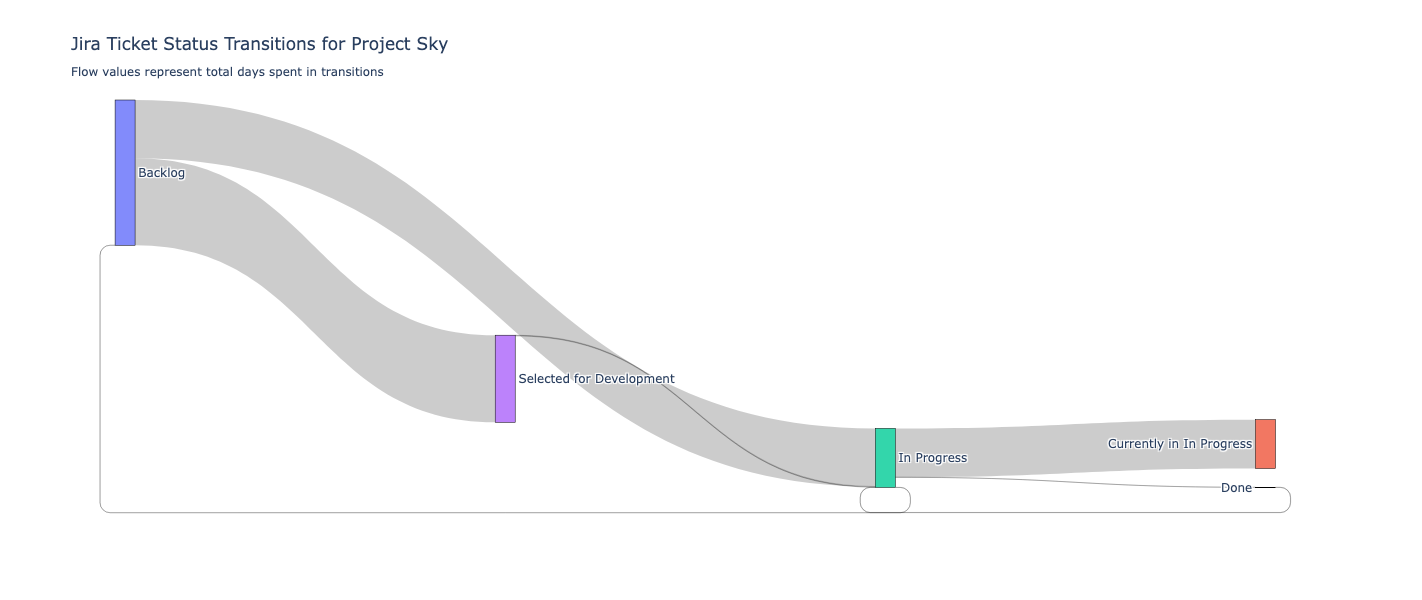


📊 Sankey Diagram Created: Jira Ticket Status Transitions for Project Sky
   • 18 transitions visualized
   • 6 unique tickets
   • 1891 total days tracked
   • Hover over flows to see ticket details

Here is your Sankey diagram showing the status transitions for the analyzed Jira tickets from Project Sky.

I can also generate other diagrams if you like:
*   **Bar Chart**: To show the total time spent in each status across all tickets.
*   **Histogram**: To visualize the distribution of time spent in a specific status for bottleneck analysis.

Let me know if you'd like to see any of these!



You:  create a histogram


Agent: For the histogram, I need to know which specific status you'd like to analyze.

Would you like to see a histogram for "In Progress", "Backlog", "Done", "To Do", or any other status?

Also, I can show you a summary of the available data if you'd like to see all the statuses present in the analyzed tickets.



You:  in progress


Agent: 


📋 Raw Transition Data for Histogram Analysis


,issue_key,source_status,target_status,transition_days,note
0,SKY-562,Backlog,In Progress,281,(from beginning)
1,SKY-562,In Progress,In Progress,22,(self-loop)
2,SKY-558,Backlog,Selected for Development,281,(from beginning)
3,SKY-558,Selected for Development,In Progress,3,
4,SKY-558,In Progress,In Progress,20,(self-loop)
5,SKY-557,Backlog,Selected for Development,282,(from beginning)
6,SKY-557,Selected for Development,In Progress,2,
7,SKY-557,In Progress,In Progress,20,(self-loop)
8,SKY-556,Backlog,Selected for Development,281,(from beginning)
9,SKY-556,Selected for Development,In Progress,2,



🔍 Found 6 time entries for 'In Progress' status:
   • SKY-562 (22d)
   • SKY-558 (20d)
   • SKY-557 (20d)
   • SKY-556 (21d)
   • SKY-555 (22d)
   • SKY-5 (370d)



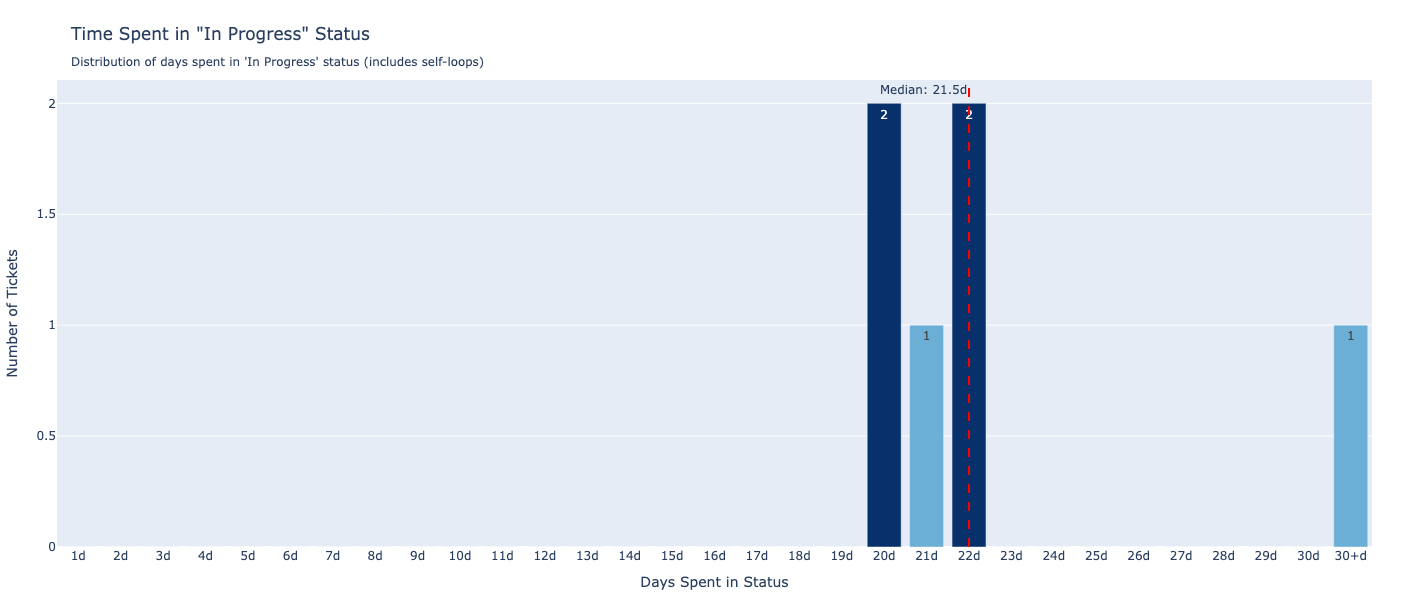


📊 Status Time Distribution: In Progress
📈 Statistics:
   • Total tickets analyzed: 6 (includes self-loops)
   • Average time: 79.2 days
   • Median time: 21.5 days
   • 90th percentile: 196.0 days
   • Range: 20 - 370 days

🔍 Bottleneck Analysis:
   • Fast (≤3 days): 0 tickets (0.0%)
   • Slow (>7 days): 6 tickets (100.0%)
   • Very slow (>14 days): 6 tickets (100.0%)

💡 Insights:
   ⚠️  High variability detected - some tickets take much longer
   🚨 Bottleneck warning - 100.0% of tickets are very slow

Here is the histogram showing the distribution of time spent in the "In Progress" status for the analyzed tickets. This chart includes statistical annotations that can help in identifying potential bottlenecks.

Would you like to explore another status with a histogram, or perhaps a bar chart to see the total time spent in each status?



You:  give me the tickets in epic sky-550


Agent: Here are the tickets associated with the epic SKY-550:

*   **SKY-564**: Enable asset actions in Marmind
    *   Status: Selected for Development
    *   Link: https://jenys.atlassian.net/browse/SKY-564
*   **SKY-563**: Assets usage tracking
    *   Status: Backlog
    *   Link: https://jenys.atlassian.net/browse/SKY-563
*   **SKY-562**: Enable asset metadata synchronisation
    *   Status: In Progress
    *   Link: https://jenys.atlassian.net/browse/SKY-562
*   **SKY-561**: Enable asset upload to DAM
    *   Status: Backlog
    *   Link: https://jenys.atlassian.net/browse/SKY-561
*   **SKY-560**: Implement user roles and permissions
    *   Status: Done
    *   Link: https://jenys.atlassian.net/browse/SKY-560
*   **SKY-558**: Implement asset assignment
    *   Status: In Progress
    *   Link: https://jenys.atlassian.net/browse/SKY-558
*   **SKY-557**: Enable asset preview in Marmind
    *   Status: In Progress
    *   Link: https://jenys.atlassian.net/browse/SKY-557
*   **SKY-

You:  clear the existing data and start fresh analysis


Agent: 🔍 [<function clear_status_transitions_data_set at 0x11e3c67a0>] State check: 18 transitions in context
Data cleared successfully!
   • Cleared: 18 transitions
   • Ready for fresh analysis
Current Status Transitions Data Summary
Transition Data: None - status transitions set is empty
Processing 9 tickets: SKY-564, SKY-563, SKY-562, SKY-561, SKY-560, SKY-558, SKY-557, SKY-556, SKY-555

📄 Processing SKY-564...
   Ticket lifetime: 302 days (created: 2024-12-14)
   ✓ Found 1 status changes + 1 current status self-loop
   ✅ SKY-564: +2 new, -0 duplicates

📄 Processing SKY-563...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ⚠️  No status changes - created self-loop: Backlog (303 days)
   ✅ SKY-563: +1 new, -0 duplicates

📄 Processing SKY-562...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ✓ Found 1 status changes + 1 current status self-loop
   ✅ SKY-562: +2 new, -0 duplicates

📄 Processing SKY-561...
   Ticket lifetime: 303 days (created: 2024-12-13)
   ⚠️  No statu

You:  sankey


Agent: 


📋 Raw Transition Data for Sankey Diagram


,issue_key,source_status,target_status,transition_days,note
0,SKY-564,Backlog,Selected for Development,281,(from beginning)
1,SKY-564,Selected for Development,Selected for Development,21,(self-loop)
2,SKY-563,Backlog,Backlog,303,(self-loop)
3,SKY-562,Backlog,In Progress,281,(from beginning)
4,SKY-562,In Progress,In Progress,22,(self-loop)
5,SKY-561,Backlog,Backlog,303,(self-loop)
6,SKY-560,Backlog,In Progress,281,(from beginning)
7,SKY-560,In Progress,Done,2,(to end)
8,SKY-560,Done,Done,21,(self-loop)
9,SKY-558,Backlog,Selected for Development,281,(from beginning)


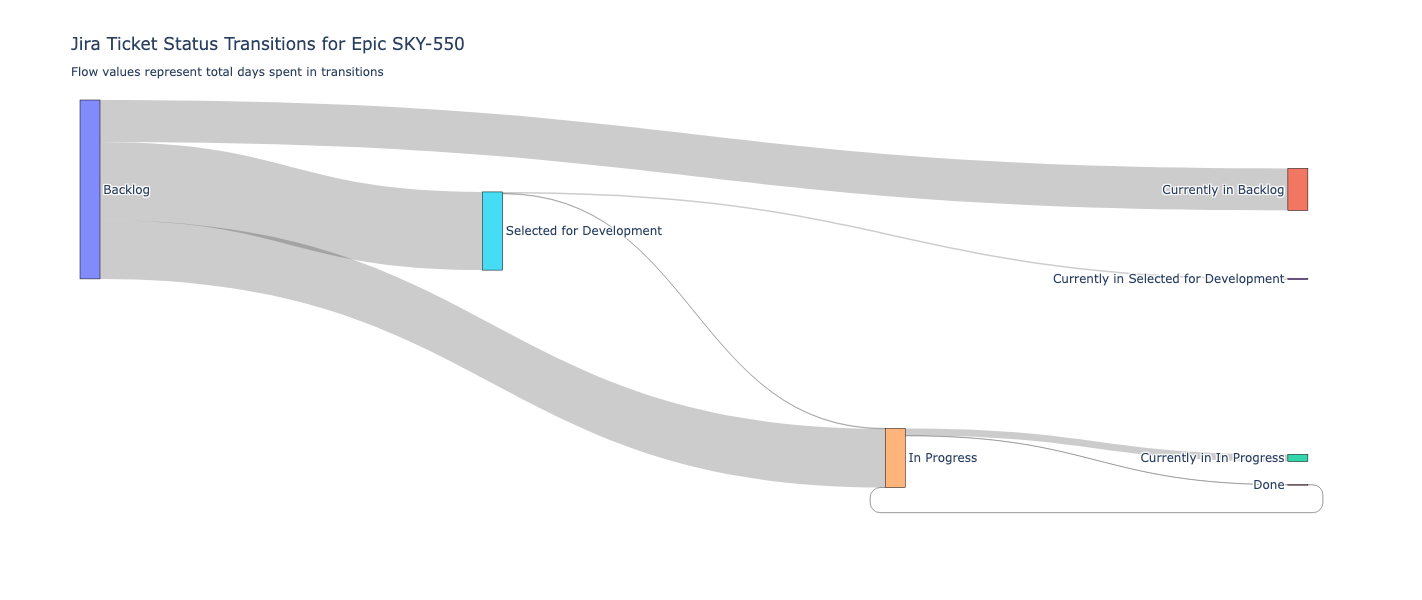


📊 Sankey Diagram Created: Jira Ticket Status Transitions for Epic SKY-550
   • 22 transitions visualized
   • 9 unique tickets
   • 2732 total days tracked
   • Hover over flows to see ticket details

Here is your Sankey diagram showing the status transitions for the analyzed Jira tickets from Epic SKY-550.

I can also generate other diagrams if you like:
*   **Bar Chart**: To show the total time spent in each status across all tickets.
*   **Histogram**: To visualize the distribution of time spent in a specific status for bottleneck analysis.

Let me know if you'd like to see any of these!



You:  create a bar chart


Agent: 


📋 Raw Transition Data for Bar Chart Analysis


,issue_key,source_status,target_status,transition_days,note
0,SKY-564,Backlog,Selected for Development,281,(from beginning)
1,SKY-564,Selected for Development,Selected for Development,21,(self-loop)
2,SKY-563,Backlog,Backlog,303,(self-loop)
3,SKY-562,Backlog,In Progress,281,(from beginning)
4,SKY-562,In Progress,In Progress,22,(self-loop)
5,SKY-561,Backlog,Backlog,303,(self-loop)
6,SKY-560,Backlog,In Progress,281,(from beginning)
7,SKY-560,In Progress,Done,2,(to end)
8,SKY-560,Done,Done,21,(self-loop)
9,SKY-558,Backlog,Selected for Development,281,(from beginning)



🔍 Time aggregation for each status:
   • In Progress: 107 days (7 entries)
     - SKY-562:22d (self-loop)
     - SKY-560:2d
     - SKY-558:20d (self-loop)
     - SKY-557:20d (self-loop)
     - SKY-556:21d (self-loop)
     - SKY-555:1d
     - SKY-555:21d (self-loop)
   • Selected for Development: 28 days (4 entries)
     - SKY-564:21d (self-loop)
     - SKY-558:3d
     - SKY-557:2d
     - SKY-556:2d



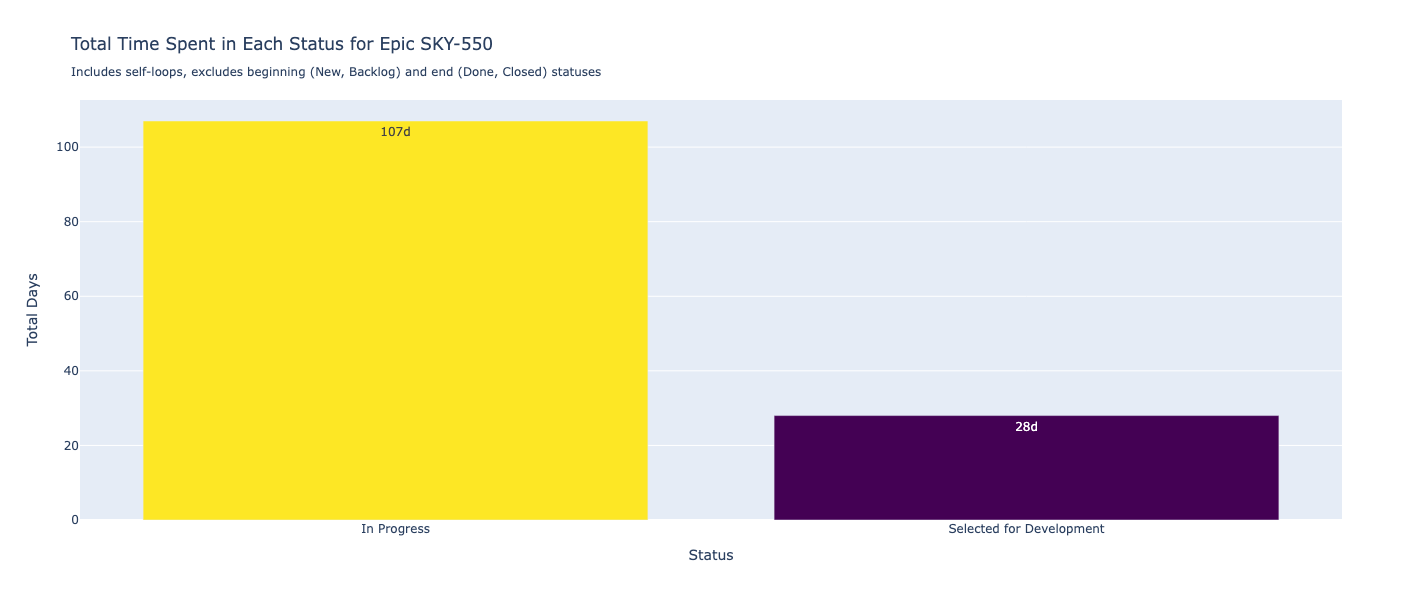


📊 Status Time Bar Chart Created: Total Time Spent in Each Status for Epic SKY-550
   • 2 active statuses analyzed
   • 135 total days across all statuses (includes self-loops)
   • 9 unique tickets
   • Excludes: Backlog, Closed, Done, New
   • Hover over bars to see ticket details

📈 Top statuses by time spent:
   1. In Progress: 107 days (7 entries)
   2. Selected for Development: 28 days (4 entries)

Here is the bar chart showing the total time spent in each status for the tickets in Epic SKY-550.

Would you like to analyze other aspects of these tickets, perhaps a histogram for a specific status, or look at a different set of tickets?



You:  create a histogram


Agent: For the histogram, I need to know which specific status you'd like to analyze.

Would you like to see a histogram for "In Progress", "Backlog", "Done", "To Do", or any other status?

I can also show you a summary of the available data if you'd like to see all the statuses present in the analyzed tickets.



You:  in progress


Agent: 


📋 Raw Transition Data for Histogram Analysis


,issue_key,source_status,target_status,transition_days,note
0,SKY-564,Backlog,Selected for Development,281,(from beginning)
1,SKY-564,Selected for Development,Selected for Development,21,(self-loop)
2,SKY-563,Backlog,Backlog,303,(self-loop)
3,SKY-562,Backlog,In Progress,281,(from beginning)
4,SKY-562,In Progress,In Progress,22,(self-loop)
5,SKY-561,Backlog,Backlog,303,(self-loop)
6,SKY-560,Backlog,In Progress,281,(from beginning)
7,SKY-560,In Progress,Done,2,(to end)
8,SKY-560,Done,Done,21,(self-loop)
9,SKY-558,Backlog,Selected for Development,281,(from beginning)



🔍 Found 6 time entries for 'In Progress' status:
   • SKY-562 (22d)
   • SKY-560 (2d)
   • SKY-558 (20d)
   • SKY-557 (20d)
   • SKY-556 (21d)
   • SKY-555 (22d)



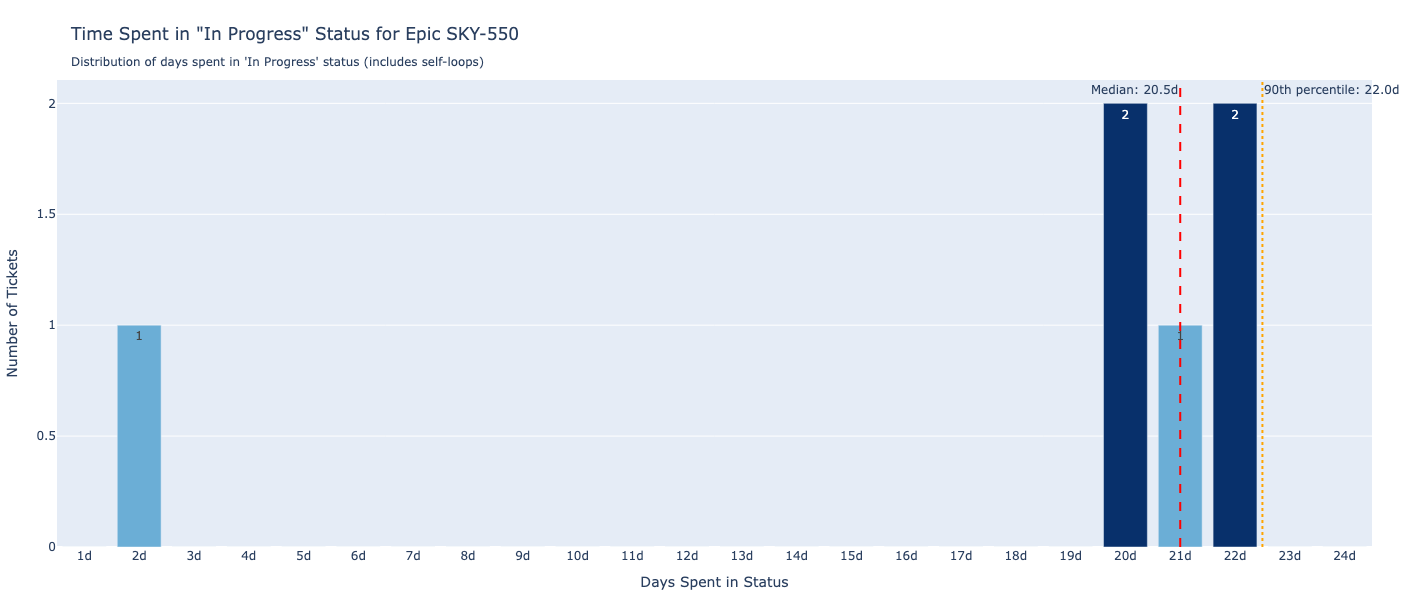


📊 Status Time Distribution: In Progress
📈 Statistics:
   • Total tickets analyzed: 6 (includes self-loops)
   • Average time: 17.8 days
   • Median time: 20.5 days
   • 90th percentile: 22.0 days
   • Range: 2 - 22 days

🔍 Bottleneck Analysis:
   • Fast (≤3 days): 1 tickets (16.7%)
   • Slow (>7 days): 5 tickets (83.3%)
   • Very slow (>14 days): 5 tickets (83.3%)

💡 Insights:
   🚨 Bottleneck warning - 83.3% of tickets are very slow

Here is the histogram showing the distribution of time spent in the "In Progress" status for the tickets in Epic SKY-550.

Is there anything else I can help you with regarding these tickets, or would you like to explore another analysis?



You:  quit


👋 Goodbye!


In [9]:
await chat()